In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
#!pip install plotly pandas

In [20]:
from kaigeo import datasets, pulsar_models
import torch

import matplotlib.pyplot as plt

In [21]:
from scipy.spatial.transform import Rotation 

In [22]:
device = torch.device("cuda")

In [23]:
session = datasets.load_session2()

In [27]:
session.target_images.shape

torch.Size([439, 128, 128, 3])

In [28]:
from pytorch3d.renderer import (
    look_at_view_transform
)


In [29]:
session.look.shape

(439, 3)

In [30]:
R, T = look_at_view_transform(eye=session.eye, at=(session.eye - session.forward))

In [31]:
session.euler = Rotation.from_matrix(R).as_euler('xyz')

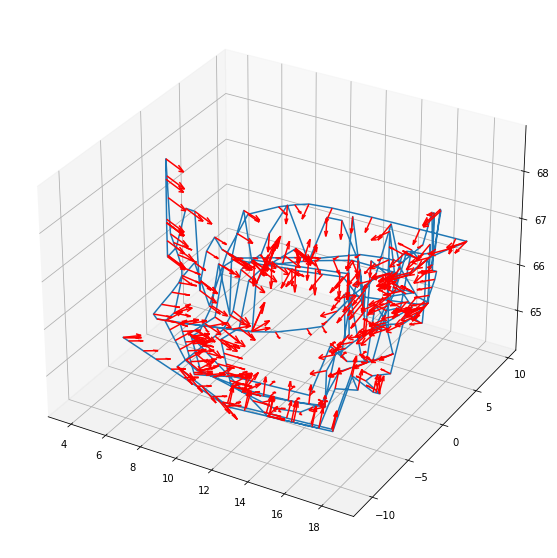

In [32]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection='3d')

ax.view_init(vertical_axis="y")

ax.plot(session.eye[:, 0], session.eye[:, 1], session.eye[:, 2])#, look[:, 0], look[:, 1], look[:, 2])
ax.quiver3D(session.eye[:, 0], 
            session.eye[:, 1], 
            session.eye[:, 2], 
            session.forward[:, 0], 
            session.forward[:, 1], 
            session.forward[:, 2], 
            color='r')

In [33]:
target_images = session.target_images[1:].to(device)[:, :100, :100]

In [34]:
m = pulsar_models.PulsarModel(
    target_images.shape[1],
    target_images.shape[2],
    target_images.shape[0],
    n_points=200000,
    ball_size=0.1,
    positions=torch.tensor(session.eye[1:]),
    angles=torch.tensor(session.euler[1:]),
    
).to(device)

In [35]:
opt = torch.optim.Adam([
    {'params': m.geometry_model.parameters(), 'lr': 1e-1},
    {'params': m.camera.parameters(), 'lr': 1e-4}
])

In [36]:
for i in range(1000):
    
    for _ in range(10):
        opt.zero_grad()

        m.set_grads(True, False)

        ri = torch.randint(len(target_images), (30,))
        Y = target_images[ri]

        y = m(ri)
    
        mse_loss = torch.nn.functional.l1_loss(y, Y)

        loss = mse_loss# * 10.0 + ball_loss
        loss.backward()
        
        opt.step()
        
    # only randomize after position
    #m.randomize()

        
    for _ in range(0):
        opt.zero_grad()

        m.set_grads(False, True)

        ri = torch.randint(len(target_images), (30,))
        Y = target_images[ri]

        y = m(ri)
    
        mse_loss = torch.nn.functional.l1_loss(y, Y)
    
        loss = mse_loss# * 10.0 + ball_loss
        loss.backward()
        
        opt.step()
    
    if i % 10 == 0:
        print(mse_loss, loss, torch.mean(m.geometry_model.rad))


tensor(0.3174, device='cuda:0', grad_fn=<L1LossBackward0>) tensor(0.3174, device='cuda:0', grad_fn=<L1LossBackward0>) tensor(0.1000, device='cuda:0')
tensor(0.1541, device='cuda:0', grad_fn=<L1LossBackward0>) tensor(0.1541, device='cuda:0', grad_fn=<L1LossBackward0>) tensor(0.1000, device='cuda:0')
tensor(0.1470, device='cuda:0', grad_fn=<L1LossBackward0>) tensor(0.1470, device='cuda:0', grad_fn=<L1LossBackward0>) tensor(0.1000, device='cuda:0')


KeyboardInterrupt: 

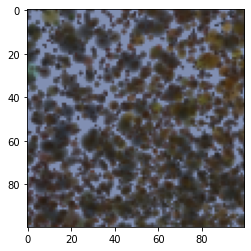

In [37]:
plt.imshow(y[20].detach().cpu().numpy())

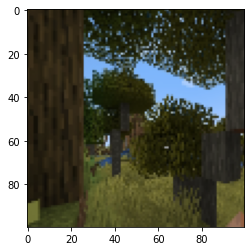

In [38]:
plt.imshow(Y[20].detach().cpu().numpy())

48991


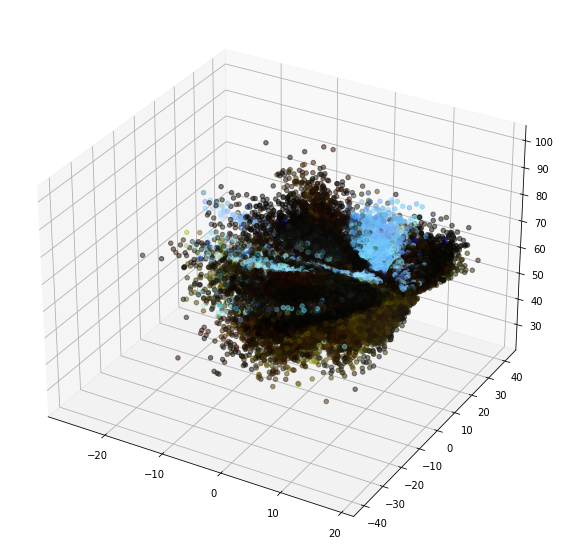

In [39]:
m.set_grads(True, True)
y = m(ri)
torch.nn.functional.mse_loss(y, Y).backward()

pulsar_models.plot3d(m) 

In [40]:
#pulsar_models.plot3d_plotly(m)

In [27]:
import open3d as o3d

# generate some neat n times 3 matrix using a variant of sync function

important = m.get_meaningful_points(True)
xyz = m.geometry_model.pos[important].detach().cpu().numpy()
colors = torch.sigmoid(m.geometry_model.col[important]).detach().cpu().numpy()

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()

pcd.points = o3d.utility.Vector3dVector(xyz)
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd])



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
